# Grocery Recommendation System

### Importing Packages

In [30]:
#importing all necessary libraries
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt
import time

import warnings
warnings.filterwarnings('ignore')

#### EDA

In [31]:
new_data = pd.read_csv('Groceries data train.csv')
new_data.head()

,Member_number,Date,itemDescription,year,month,day,day_of_week
0,3021,30/01/2015,frankfurter,2015,1,30,4
1,1292,24/10/2015,pork,2015,10,24,5
2,4206,4/04/2014,root vegetables,2014,4,4,4
3,4369,25/08/2015,onions,2015,8,25,1
4,1522,1/07/2014,waffles,2014,7,1,1


In [32]:
new_data = new_data.drop(columns=['year','month','day','day_of_week'])
new_data.head()

,Member_number,Date,itemDescription
0,3021,30/01/2015,frankfurter
1,1292,24/10/2015,pork
2,4206,4/04/2014,root vegetables
3,4369,25/08/2015,onions
4,1522,1/07/2014,waffles


In [33]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27000 entries, 0 to 26999
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Member_number    27000 non-null  int64 
 1   Date             27000 non-null  object
 2   itemDescription  27000 non-null  object
dtypes: int64(1), object(2)
memory usage: 632.9+ KB


In [34]:
len(new_data["Member_number"].unique())

3872

### Visualization

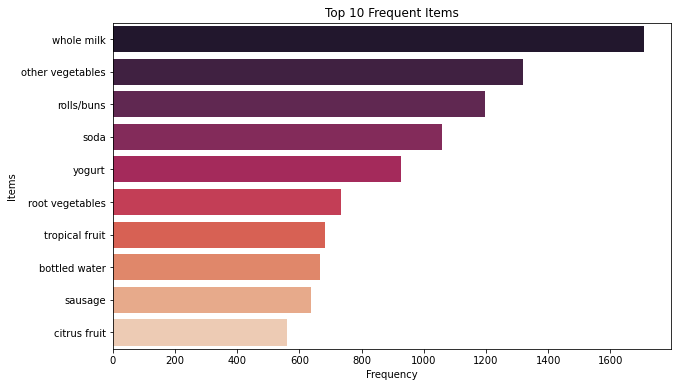

In [35]:
# Plotting the frequency of top 10 items bought
item_counts = new_data['itemDescription'].value_counts().sort_values(ascending=False) # calculate the frequency of each item
top_items = item_counts[:10] # select only the top 10 frequent items
items = top_items.index.tolist() # create lists of items and counts for the plot
counts = top_items.values.tolist()
plt.figure(figsize=(10, 6))
sns.barplot(x=counts, y=items, palette="rocket")# create a horizontal bar plot using seaborn
plt.xlabel("Frequency")
plt.ylabel("Items")
plt.title("Top 10 Frequent Items")# add labels and title to the plot
plt.show()

In [36]:
#Function to preprocess the data before performing pattern mining and collaborative filtering
def preprocess_data(filename):
    data = pd.read_csv(filename) #reading the csv file into a dataframe
    data = data.drop(columns=['year','month','day','day_of_week']) #dropping unnecessary columns
    data['Date']= pd.to_datetime(data['Date']) #converting string to timestamp datatype
    #print(data.head())
    
    data['single_transaction'] = data['Member_number'].astype(str)+'_'+data['Date'].astype(str) #merging Member_number and Date
    df = pd.crosstab(data['single_transaction'], data['itemDescription']) #creating a cross tabular dataframe
    #print(df.head())
    
    return df

### Pattern Mining 

In [37]:
#Function to encode all the values in a dataframe into 1 and 0
def encode(item_freq):
    res = 0
    if item_freq > 0:
        res = 1
    return res

In [38]:
#Function to predict items bought based on rules created
def predict_items(rules, items):
    predicted_items = [] #list to store the predicted items
    confidence_values = [] #list to store the confidence values
    support_values =[] #list to store the support values
    
    for index, row in rules.iterrows():
        # get the items in the antecedent and consequent of the rule
        antecedent = row["antecedents"]
        consequent = row["consequents"]
        #get the confidence and support values of the items
        confidence = row["confidence"]
        support = row["support"]
        
        # check if all the items in the antecedent are in the purchased items
        if antecedent.issubset(items):
            predicted_items.append(list(consequent)[0])
            confidence_values.append(confidence)
            support_values.append(support)
    
    predicted_items = pd.DataFrame({'confidence':confidence_values, 'support':support_values, 'predicted_items':predicted_items})
    
    # return the list of predicted items
    return predicted_items

In [39]:
#Function to perform pattern mining using Apriori and association rules
def frequent_pattern_mining(filename, search_item, min_support = 0.001, metric = "lift", min_threshold = 0.08):
    df = preprocess_data(filename)
    #print(df.head())
    transactions = df.applymap(encode)
    #print(transactions.head())
        
    frequent_itemsets = apriori(transactions, min_support = min_support, use_colnames = True)
    #print(frequent_itemsets)
    rules = association_rules(frequent_itemsets, metric = metric, min_threshold = min_threshold)
    #print(rules)
    items = set(search_item.split())
    result = predict_items(rules, items)
    
    return result

In [40]:
#Parameters
filename = "Groceries data train.csv"
search_item = "pork"
min_support = 0.001
metric = "lift"
min_threshold = 0.8
no_of_recommendations = 3

#Pattern mining
print(f"The frequent items bought with {search_item} are:")
start_pattern_time = time.time()
patterns = frequent_pattern_mining(filename, search_item, min_support, metric, min_threshold)
end_pattern_time = time.time()
print(patterns)

time_taken_pattern = round((end_pattern_time-start_pattern_time),2)


The frequent items bought with pork are:
   confidence   support   predicted_items
0    0.039474  0.001079         margarine
1    0.086842  0.002374  other vegetables
2    0.063158  0.001726              soda
3    0.097368  0.002662        whole milk


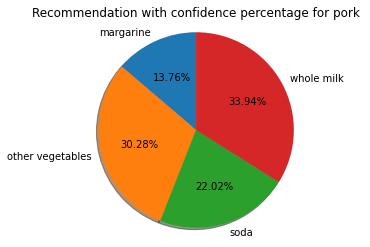

In [41]:
import matplotlib.pyplot as plt


plt.pie(patterns['confidence'],labels=patterns['predicted_items'], startangle=90, shadow=True, autopct='%1.2f%%')

plt.title(f'Recommendation with confidence percentage for {search_item}')

plt.axis('equal')

plt.show()

### Collaborative filtering

In [42]:
#Function to perform collaborative filtering method
def collaborative_filtering(filename, search_item):
    df = preprocess_data(filename)
    
    #Calculating cosine similarity of train dataset
    item_similarity = cosine_similarity(df.T)
    item_similarity_df = pd.DataFrame(item_similarity, index=df.columns, columns=df.columns)
    #print(item_similarity_df.head())
    
    #Recommendation generation of dataset using similarity score and collaborative filtering
    item_idx = df.columns.get_loc(search_item)
    sim_scores = item_similarity[item_idx]
    sim_scores_df = pd.DataFrame({'similarity_scores': sim_scores, 'recommended_items': df.columns})
    sim_scores_df = sim_scores_df.sort_values(by='similarity_scores', ascending=False)
    
    return sim_scores_df

In [43]:
#Parameters
filename = "Groceries data train.csv"
search_item = "pork"
min_support = 0.001
metric = "lift"
min_threshold = 0.8
no_of_recommendations = 3

#recommendation through data
print(f"\nTop {no_of_recommendations} recommended items to buy along with {search_item} are:")
start_recommend_time = time.time()
recommendations = collaborative_filtering(filename, search_item)
end_recommend_time = time.time()
print(recommendations.iloc[1:no_of_recommendations+1])

#Timing estimation
time_taken_colaborative = round((end_recommend_time-start_recommend_time),2)
total_time = time_taken_pattern+time_taken_colaborative
print(f"\nTime taken to load this dataset is {total_time} sec")


Top 3 recommended items to buy along with pork are:
     similarity_scores recommended_items
102           0.046227  other vegetables
164           0.044611        whole milk
88            0.041956         margarine

Time taken to load this dataset is 5.77 sec


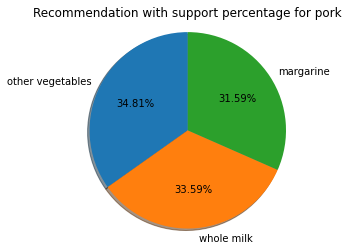

In [44]:
import matplotlib.pyplot as plt


plt.pie(recommendations.iloc[1:no_of_recommendations+1]['similarity_scores'],labels=recommendations.iloc[1:no_of_recommendations+1]['recommended_items'], startangle=90, shadow=True, autopct='%1.2f%%')

plt.title(f'Recommendation with support percentage for {search_item}')

plt.axis('equal')

plt.show()

### Recommendation through patterns

In [45]:
#recommendation through patterns
print("Pattern:", list(patterns['predicted_items']))
for index, row in patterns.iterrows():
    predicted_items = row["predicted_items"]
    print(f"\nTop {no_of_recommendations} recommended items to buy along with pattern of {predicted_items} are:")
    recommendations = collaborative_filtering(filename, predicted_items)
    print(recommendations.iloc[1:no_of_recommendations+1])

Pattern: ['margarine', 'other vegetables', 'soda', 'whole milk']

Top 3 recommended items to buy along with pattern of margarine are:
     similarity_scores recommended_items
138           0.046498              soda
111           0.041956              pork
102           0.039132  other vegetables

Top 3 recommended items to buy along with pattern of other vegetables are:
     similarity_scores recommended_items
138           0.066703              soda
164           0.065697        whole milk
56            0.060942       frankfurter

Top 3 recommended items to buy along with pattern of soda are:
     similarity_scores recommended_items
102           0.066703  other vegetables
164           0.065227        whole milk
130           0.055992           sausage

Top 3 recommended items to buy along with pattern of whole milk are:
     similarity_scores recommended_items
165           0.075707            yogurt
122           0.075035        rolls/buns
130           0.070839           sausage


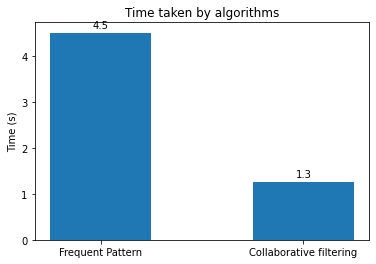

In [46]:
import matplotlib.pyplot as plt
import numpy as np

# Example data
algorithms = ['Frequent Pattern', 'Collaborative filtering']
times = [time_taken_pattern, time_taken_colaborative]  # in seconds

# Create bar chart
x = np.arange(len(algorithms))
width = 0.5

fig, ax = plt.subplots()
rects = ax.bar(x, times, width)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Time (s)')
ax.set_title('Time taken by algorithms')
ax.set_xticks(x)
ax.set_xticklabels(algorithms)

# Add labels on top of each bar
for rect in rects:
    height = rect.get_height()
    ax.annotate(f'{height:.1f}', xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3), textcoords='offset points', ha='center', va='bottom')

# Show plot
plt.show()


### Generating resuts on the test data

In [47]:
#Parameters
filename = "Groceries data test.csv"
search_item = "yogurt"
min_support = 0.001
metric = "lift"
min_threshold = 0.8
no_of_recommendations = 3

#Pattern mining
print(f"The frequent items bought with {search_item} are:")
results = frequent_pattern_mining(filename, search_item, min_support, metric, min_threshold)
print(results)

The frequent items bought with yogurt are:
   confidence   support predicted_items
0    0.022333  0.001026          pastry
1    0.024814  0.001140   shopping bags


In [48]:
#recommendation through data
print(f"\nTop {no_of_recommendations} recommended items to buy along with {search_item} are:")
recommendations = collaborative_filtering(filename, search_item)
print(recommendations.iloc[1:no_of_recommendations+1])


Top 3 recommended items to buy along with yogurt are:
     similarity_scores recommended_items
129           0.032070     shopping bags
90            0.030554   misc. beverages
103           0.029301            pastry


In [49]:
#recommendation through patterns
print("Pattern:", list(patterns['predicted_items']))
for index, row in patterns.iterrows():
    predicted_items = row["predicted_items"]
    print(f"\nTop {no_of_recommendations} recommended items to buy along with pattern of {predicted_items} are:")
    recommendations = collaborative_filtering(filename, predicted_items)
    print(recommendations.iloc[1:no_of_recommendations+1])

Pattern: ['margarine', 'other vegetables', 'soda', 'whole milk']

Top 3 recommended items to buy along with pattern of margarine are:
     similarity_scores recommended_items
120           0.032553   root vegetables
132           0.028583    snack products
12            0.025854            brandy

Top 3 recommended items to buy along with pattern of other vegetables are:
     similarity_scores recommended_items
119           0.043278        rolls/buns
159           0.041841        whole milk
11            0.035202     bottled water

Top 3 recommended items to buy along with pattern of soda are:
     similarity_scores recommended_items
17            0.037905           candles
149           0.030949               tea
53            0.030392    flower (seeds)

Top 3 recommended items to buy along with pattern of whole milk are:
     similarity_scores recommended_items
100           0.041841  other vegetables
119           0.039775        rolls/buns
151           0.033518    tropical fruit
